<a href="https://www.kaggle.com/code/marinanasser/image-processing-project-3?scriptVersionId=288694702" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/name_mapping.csv
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/survival_data.csv
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_seg.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_t1.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_t1ce.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_flair.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_2013_27_1/BraTS19_2013_27_1_t2.nii
/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training/HGG/BraTS19_CBICA_AQA_1/BraTS19_CBICA_AQA_1_flair.nii
/kaggle/input/

# Configuration 


In [2]:
import tensorflow as tf
import numpy as np
import nibabel as nib
import os
from glob import glob
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


IMG_WIDTH = 256
IMG_HEIGHT = 256
BATCH_SIZE = 1
BUFFER_SIZE = 400
EPOCHS = 50 # Adjust as needed for convergence
LAMBDA = 100
BRAIN_DATA_DIR = '/kaggle/input/brain-tumor-segmentation-brats-2019/MICCAI_BraTS_2019_Data_Training'


2025-12-27 13:20:29.621855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766841629.644165    1107 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766841629.650871    1107 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Visualize sample data slices
def visualize_sample_data(train_ds, num_samples=3):
    """Visualize sample input and target pairs from the dataset."""
    plt.figure(figsize=(15, 5 * num_samples))
    
    for i, (input_img, target_img) in enumerate(train_ds.take(num_samples)):
        # Denormalize from [-1, 1] to [0, 1]
        input_display = (input_img[0].numpy().squeeze() + 1) / 2
        target_display = (target_img[0].numpy().squeeze() + 1) / 2
        
        # Input image
        plt.subplot(num_samples, 2, i*2 + 1)
        plt.imshow(input_display, cmap='gray')
        plt.title(f'Input Image {i+1} (T2)')
        plt.axis('off')
        
        # Target image
        plt.subplot(num_samples, 2, i*2 + 2)
        plt.imshow(target_display, cmap='gray')
        plt.title(f'Target Image {i+1} (T1)')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_data_pairs.png', dpi=150, bbox_inches='tight')
    plt.show()

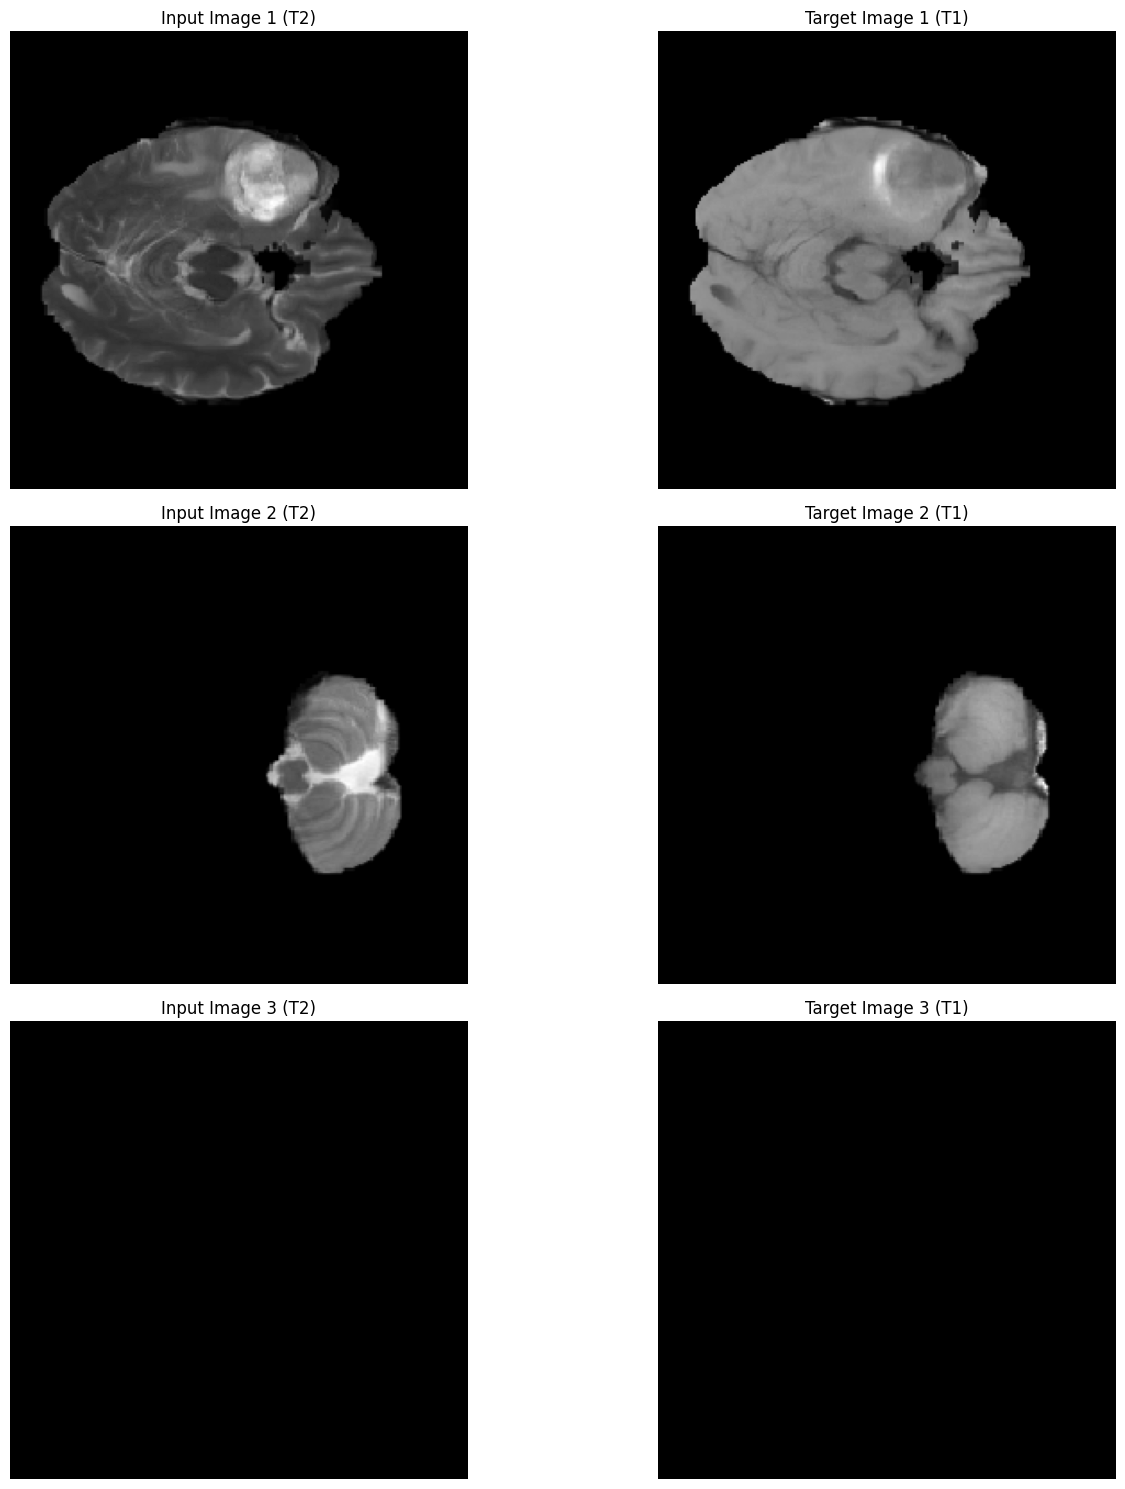

In [20]:
visualize_sample_data(train_dataset_2, num_samples=3)

In [21]:
def generate_images(model, test_input, tar, save_filename=None):
    """Generate and display predictions."""
    prediction = model(test_input, training=False)
    
    plt.figure(figsize=(15, 5))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image (T2)', 'Ground Truth (T1)', 'Predicted Image (T1)']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        # Denormalize from [-1, 1] to [0, 1]
        img = (display_list[i].numpy().squeeze() + 1) / 2
        plt.imshow(img, cmap='gray')
        plt.title(title[i])
        plt.axis('off')
    
    if save_filename:
        plt.savefig(save_filename, dpi=150, bbox_inches='tight')
    plt.show()


In [22]:
def fit_with_visualization(train_ds, test_ds, epochs, generator, discriminator):
    """Training loop with visualization and metrics tracking."""
    print(f"Starting training for {epochs} epochs...")
    
    # Get a sample for visualization
    example_input, example_target = next(iter(test_ds.take(1)))
    
    # Lists to store metrics
    psnr_history = []
    ssim_history = []
    
    for epoch in range(epochs):
        # TRAIN
        for n, (input_image, target) in train_ds.enumerate():
            if n % 100 == 0:
                print(f'\rEpoch {epoch + 1}/{epochs} | Step {n}', end='')
            train_step(input_image, target, generator, discriminator)
        
        # EVALUATE
        avg_psnr, avg_ssim = calculate_metrics(test_ds, generator)
        psnr_history.append(avg_psnr)
        ssim_history.append(avg_ssim)
        
        print(f'\n--- Epoch {epoch + 1} Evaluation ---')
        print(f'PSNR: {avg_psnr:.2f}')
        print(f'SSIM: {avg_ssim:.4f}')
        print('-' * 40)
        
        # Visualize predictions every 5 epochs
        if (epoch + 1) % 5 == 0:
            generate_images(generator, example_input, example_target, 
                          f'prediction_epoch_{epoch+1}.png')
    
    return psnr_history, ssim_history


# plot training metrics
def plot_training_metrics(psnr_history, ssim_history):
    """Plot PSNR and SSIM over epochs."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs_range = range(1, len(psnr_history) + 1)
    
    # PSNR plot
    ax1.plot(epochs_range, psnr_history, 'b-', linewidth=2, marker='o')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_title('Peak Signal-to-Noise Ratio over Epochs', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # SSIM plot
    ax2.plot(epochs_range, ssim_history, 'r-', linewidth=2, marker='s')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('SSIM', fontsize=12)
    ax2.set_title('Structural Similarity Index over Epochs', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_metrics.png', dpi=150, bbox_inches='tight')
    plt.show()

def evaluate_and_visualize(test_ds, generator, num_samples=5):
    """Evaluate model and create comprehensive visualization."""
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    all_psnr = []
    all_ssim = []
    
    for idx, (input_image, real_target) in enumerate(test_ds.take(num_samples)):
        # Generate prediction
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        input_display = (input_image[0].numpy().squeeze() + 1) / 2
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Calculate metrics
        p = psnr(real_display, synthetic_display, data_range=1.0)
        s = ssim(real_display, synthetic_display, data_range=1.0, channel_axis=None)
        all_psnr.append(p)
        all_ssim.append(s)
        
        # Calculate difference map
        diff = np.abs(real_display - synthetic_display)
        
        # Plot
        axes[idx, 0].imshow(input_display, cmap='gray')
        axes[idx, 0].set_title(f'Input (T2)')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(real_display, cmap='gray')
        axes[idx, 1].set_title(f'Ground Truth (T1)')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(synthetic_display, cmap='gray')
        axes[idx, 2].set_title(f'Generated (T1)\nPSNR: {p:.2f} dB')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(diff, cmap='hot')
        axes[idx, 3].set_title(f'Difference Map\nSSIM: {s:.4f}')
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('comprehensive_evaluation.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nAverage PSNR: {np.mean(all_psnr):.2f} dB")
    print(f"Average SSIM: {np.mean(all_ssim):.4f}")

def analyze_data_distribution(train_ds):
    """Analyze and visualize the distribution of pixel intensities."""
    input_pixels = []
    target_pixels = []
    
    for input_img, target_img in train_ds.take(100):
        input_pixels.extend(input_img.numpy().flatten())
        target_pixels.extend(target_img.numpy().flatten())
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Input distribution
    axes[0].hist(input_pixels, bins=50, alpha=0.7, color='blue', edgecolor='black')
    axes[0].set_xlabel('Pixel Intensity', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_title('Input Image (T2) Pixel Distribution', fontsize=14)
    axes[0].grid(True, alpha=0.3)
    
    # Target distribution
    axes[1].hist(target_pixels, bins=50, alpha=0.7, color='red', edgecolor='black')
    axes[1].set_xlabel('Pixel Intensity', fontsize=12)
    axes[1].set_ylabel('Frequency', fontsize=12)
    axes[1].set_title('Target Image (T1) Pixel Distribution', fontsize=14)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('data_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()


# U-Net/PatchGAN Helper Blocks

In [3]:

def downsample(filters, size, apply_batchnorm=True):
    """Downsampling block for the U-Net Encoder."""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                               kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    """Upsampling block for the U-Net Decoder."""
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                        padding='same',
                                        kernel_initializer=initializer,
                                        use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

# Model Definition (Pix2Pix)
## Pix2Pix uses a U-Net as its Generator and a PatchGAN as its Discriminator.

### A. Generator (U-Net)
The Generator takes the input image (e.g., T1) and tries to output the target image (e.g., T2).
### B. Discriminator (PatchGAN)
The Discriminator tries to distinguish between a real image pair (T1, Real T2) and a fake image pair (T1, Synthetic T2).

In [4]:
def Generator():
    """Defines the U-Net Generator model."""
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])

    # Encoder (Downsampling)
    down_stack = [
        downsample(64, 4, apply_batchnorm=False),  # (bs, 128, 128, 64)
        downsample(128, 4),  # (bs, 64, 64, 128)
        downsample(256, 4),  # (bs, 32, 32, 256)
        downsample(512, 4),  # (bs, 16, 16, 512)
        downsample(512, 4),  # (bs, 8, 8, 512)
        downsample(512, 4),  # (bs, 4, 4, 512)
        downsample(512, 4),  # (bs, 2, 2, 512)
        downsample(512, 4),  # (bs, 1, 1, 512)
    ]

    # Decoder (Upsampling)
    up_stack = [
        upsample(512, 4, apply_dropout=True),  # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),  # (bs, 8, 8, 1024)
        upsample(512, 4),                      # (bs, 16, 16, 1024)
        upsample(256, 4),                      # (bs, 32, 32, 512)
        upsample(128, 4),                      # (bs, 64, 64, 256)
        upsample(64, 4),                       # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same',
                                          kernel_initializer=initializer,
                                          activation='tanh')  # (bs, 256, 256, 1)

    x = inputs
    skips = []
    
    # Downsampling layers
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1]) # Skip the bottleneck output itself
    
    # Upsampling layers and skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

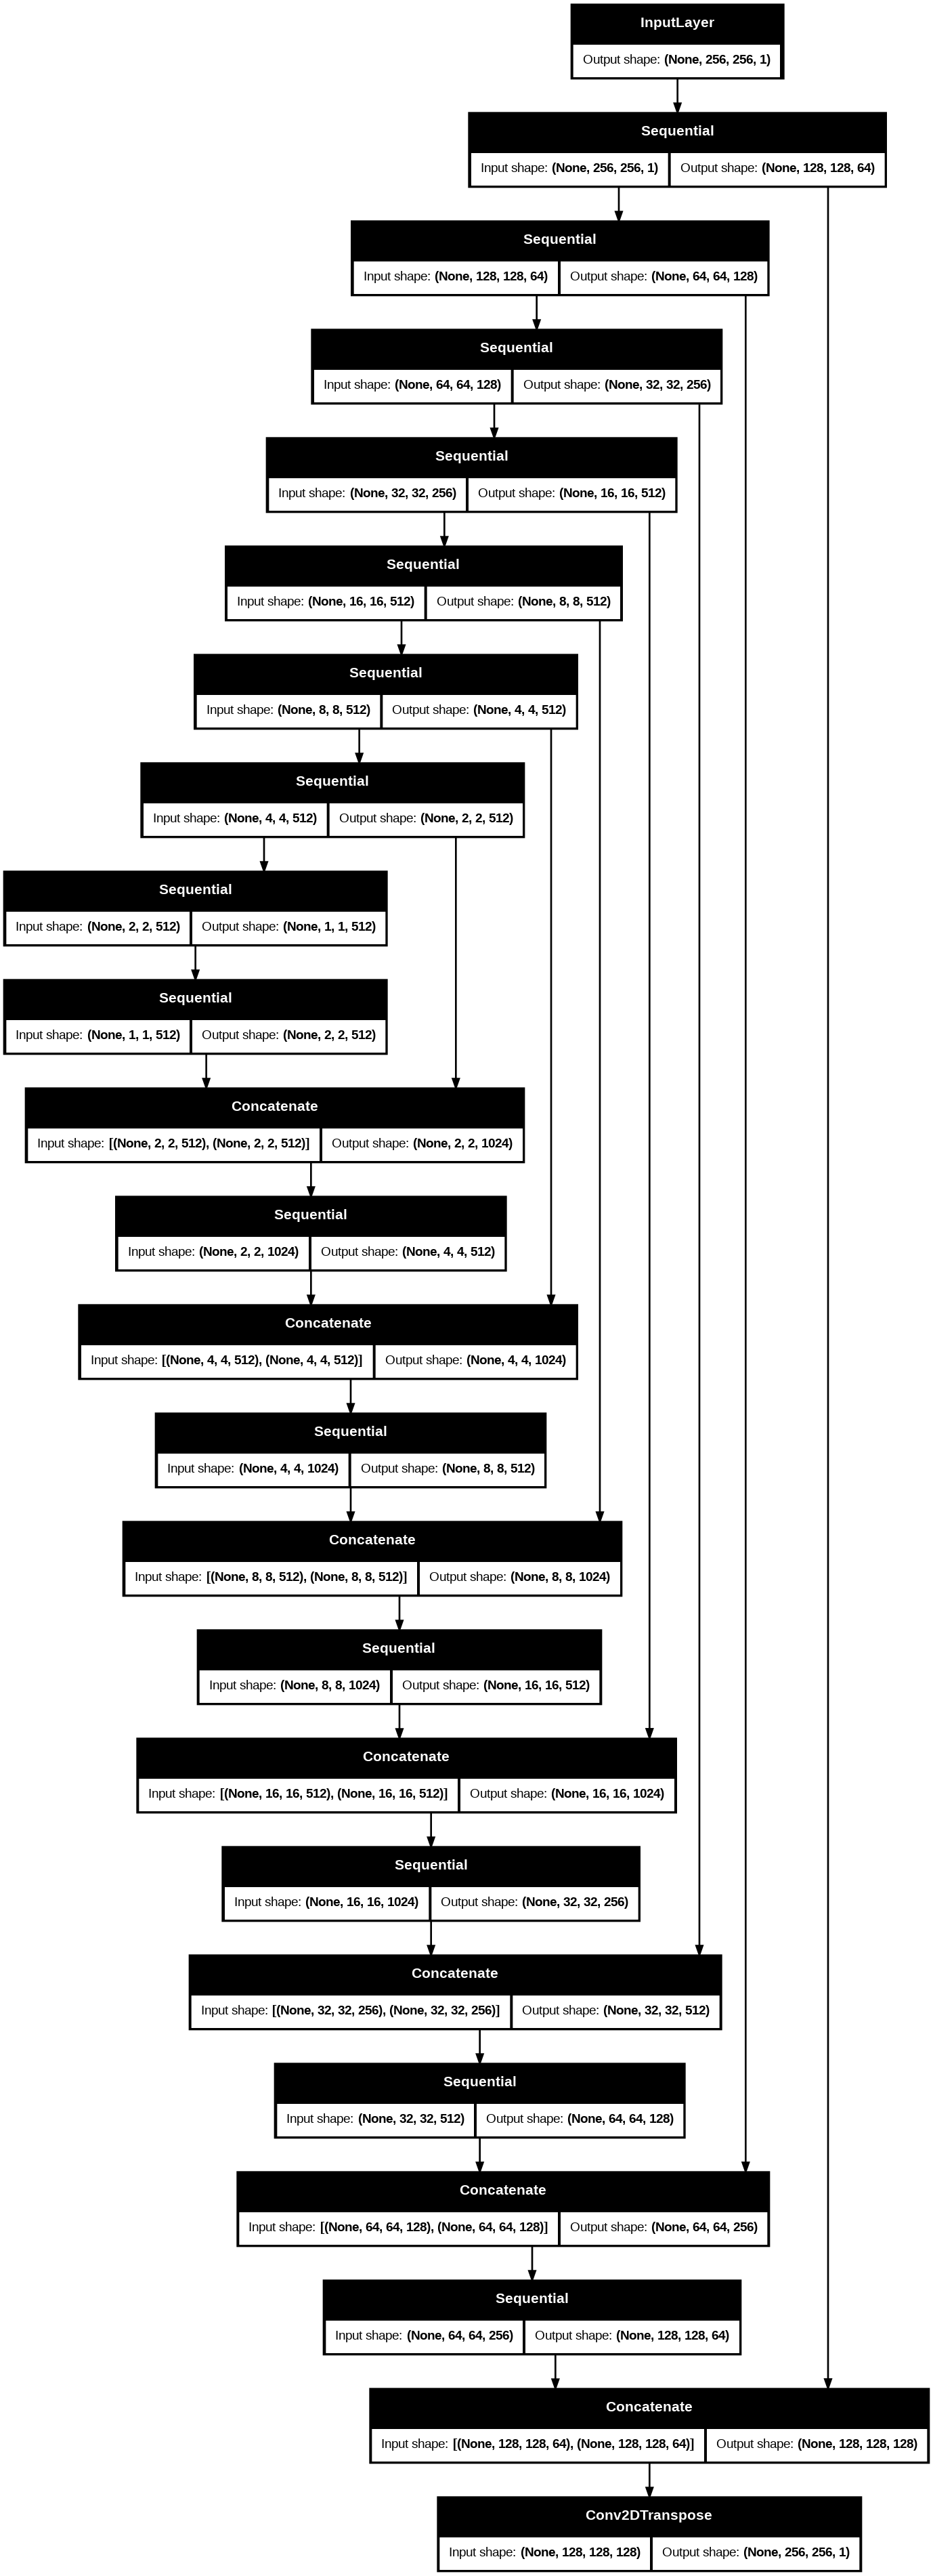

In [14]:
from tensorflow.keras.utils import plot_model

generator = Generator()
plot_model(generator, show_shapes=True, to_file='generator_architecture.png', dpi=96)

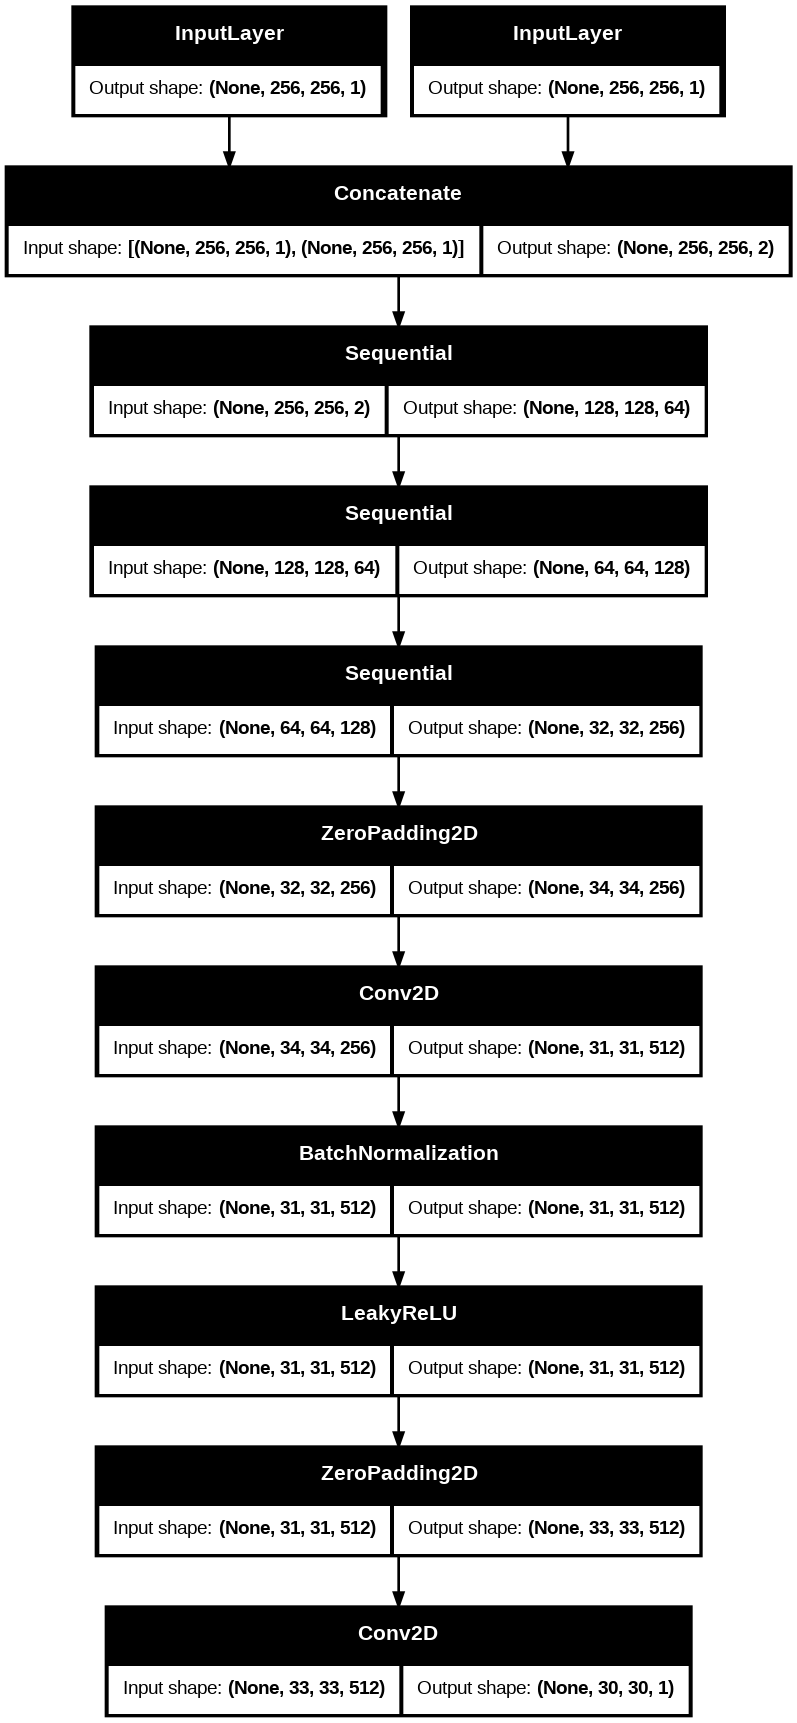

In [17]:
discriminator = Discriminator()
plot_model(discriminator, show_shapes=True, to_file='discriminator_architecture.png', dpi=96)

In [5]:
def Discriminator():
    """Defines the PatchGAN Discriminator model."""
    initializer = tf.random_normal_initializer(0., 0.02)

    # Input (e.g., T1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    # Target (e.g., Real T2 or Fake T2)
    tar = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='target_image')

    # Concatenate Input and Target along the channel axis
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, 2)

    # C64
    down1 = downsample(64, 4, False)(x)  # (bs, 128, 128, 64)
    # C128
    down2 = downsample(128, 4)(down1)  # (bs, 64, 64, 128)
    # C256
    down3 = downsample(256, 4)(down2)  # (bs, 32, 32, 256)

    # C512
    # Downsample again, but use a stride of 1
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    # Output (A single value per patch)
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)

In [11]:
def visualize_model_architecture():
    """Display model architecture information."""
    print("\n" + "="*70)
    print(" " * 20 + "MODEL ARCHITECTURE SUMMARY")
    print("="*70)
    
    print("\n📊 GENERATOR (U-Net)")
    print("-" * 70)
    print(f"Total Parameters: {generator_t2_t1.count_params():,}")
    print(f"Input Shape: (256, 256, 1)")
    print(f"Output Shape: (256, 256, 1)")
    print(f"Architecture: Encoder-Decoder with Skip Connections")
    print(f"Activation: Tanh (output layer)")
    
    print("\n📊 DISCRIMINATOR (PatchGAN)")
    print("-" * 70)
    print(f"Total Parameters: {discriminator_t2_t1.count_params():,}")
    print(f"Input Shape: (256, 256, 2) [concatenated input+target]")
    print(f"Output Shape: (30, 30, 1) [patch predictions]")
    print(f"Architecture: Convolutional Classifier")
    
    print("\n⚙️ TRAINING CONFIGURATION")
    print("-" * 70)
    print(f"Loss Function: Binary Cross-Entropy + L1 Loss")
    print(f"L1 Weight (λ): {LAMBDA}")
    print(f"Optimizer: Adam (lr=2e-4, β₁=0.5)")
    print(f"Batch Size: {BATCH_SIZE}")
    print(f"Image Size: {IMG_WIDTH}x{IMG_HEIGHT}")
    print(f"Training Epochs: {EPOCHS}")
    print("="*70 + "\n")

visualize_model_architecture()


                    MODEL ARCHITECTURE SUMMARY

📊 GENERATOR (U-Net)
----------------------------------------------------------------------
Total Parameters: 54,419,713
Input Shape: (256, 256, 1)
Output Shape: (256, 256, 1)
Architecture: Encoder-Decoder with Skip Connections
Activation: Tanh (output layer)

📊 DISCRIMINATOR (PatchGAN)
----------------------------------------------------------------------
Total Parameters: 2,766,337
Input Shape: (256, 256, 2) [concatenated input+target]
Output Shape: (30, 30, 1) [patch predictions]
Architecture: Convolutional Classifier

⚙️ TRAINING CONFIGURATION
----------------------------------------------------------------------
Loss Function: Binary Cross-Entropy + L1 Loss
L1 Weight (λ): 100
Optimizer: Adam (lr=2e-4, β₁=0.5)
Batch Size: 1
Image Size: 256x256
Training Epochs: 50



When running the create_dataset function, we are loading all selected 3D NIfTI volumes, extracting all 2D slices, and storing them as massive NumPy arrays (input_array and target_array) in our computer's main memory (RAM). Since there are many patients (volumes) and each volume yields 155 or more 256x256 slices, the total number of 2D slices quickly consumes all available RAM.

so i put a limit


In [6]:
# --- Configuration (Set this low to start) ---
PATIENT_LIMIT = 10 # <--- NEW: Only process this many patients

# (The existing load_nifti_to_slices function is assumed to be defined here)

def load_nifti_to_slices(file_path):
    try:
        img = nib.load(file_path)
        data = img.get_fdata().astype(np.float32)

        # Robust intensity normalization (FIX)
        p1, p99 = np.percentile(data, (1, 99))
        data = np.clip(data, p1, p99)
        data = (data - p1) / (p99 - p1 + 1e-7)  # [0,1]

        slices = [data[:, :, i] for i in range(data.shape[2])]
        return np.stack(slices, axis=0)

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return np.empty((0, 256, 256), dtype=np.float32)



def create_dataset(data_dir, task='t1_to_t2', max_patients=None): # <--- MAX PATIENTS ADDED
    """
    Finds paired T1 and T2 volumes, limits processing to max_patients, 
    and creates a tf.data.Dataset.
    """
    
    # 1. Corrected File Search (.nii extension confirmed from previous step)
    search_pattern = os.path.join(data_dir, '*/*/*t*.nii')
    all_files = glob(search_pattern, recursive=False)
    
    # Filter and sort the T1 and T2 files
    t1_files = sorted([f for f in all_files if f.endswith('t1.nii') and 't1ce' not in f])
    t2_files = sorted([f for f in all_files if f.endswith('t2.nii')])
    
    # Ensure lists are the same length for zipping (should be handled by BraTS structure)
    min_files = min(len(t1_files), len(t2_files))
    
    # --- Apply Patient Limit ---
    if max_patients is not None:
        min_files = min(min_files, max_patients)
    
    t1_files = t1_files[:min_files]
    t2_files = t2_files[:min_files]
    
    print(f"\nProcessing {min_files} patients out of {min(len(t1_files), len(t2_files))} potential pairs.")

    all_input_slices = []
    all_target_slices = []

    # 2. Pair and Process
    for t1_path, t2_path in zip(t1_files, t2_files):
        
        t1_slices = load_nifti_to_slices(t1_path)
        t2_slices = load_nifti_to_slices(t2_path)
        
        if t1_slices.size == 0 or t2_slices.size == 0:
            continue
            
        # ... (rest of the slice processing logic) ...
        min_slices = min(t1_slices.shape[0], t2_slices.shape[0])

        if task == 't1_to_t2':
            all_input_slices.append(t1_slices[:min_slices])
            all_target_slices.append(t2_slices[:min_slices])
        elif task == 't2_to_t1':
            all_input_slices.append(t2_slices[:min_slices])
            all_target_slices.append(t1_slices[:min_slices])

    # 3. Concatenate and Split
    if not all_input_slices:
        raise ValueError("After processing, no valid slices remain to concatenate. Dataset is empty.")
        
    input_array = np.concatenate(all_input_slices, axis=0)[..., np.newaxis].astype(np.float32)
    target_array = np.concatenate(all_target_slices, axis=0)[..., np.newaxis].astype(np.float32)

    print(f"Total paired slices created for {task}: {input_array.shape[0]}")
    
    # ... (rest of the splitting logic) ...
    data_size = input_array.shape[0]
    train_size = int(0.9 * data_size)
    
    train_input = input_array[:train_size]
    train_target = target_array[:train_size]
    test_input = input_array[train_size:]
    test_target = target_array[train_size:]

    train_ds = tf.data.Dataset.from_tensor_slices((train_input, train_target))
    test_ds = tf.data.Dataset.from_tensor_slices((test_input, test_target))
    
    return train_ds, test_ds

# Preprocessing functions


In [7]:
def resize(image, height, width):
    return tf.image.resize(image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

def normalize(input_image, real_image):
    # Scale to [-1, 1] for Generator Tanh output
    input_image = (input_image * 2) - 1
    real_image = (real_image * 2) - 1
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    # Resizing to 286x286
    input_image = resize(input_image, 286, 286)
    real_image = resize(real_image, 286, 286)

    # Random cropping back to 256x256
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 1])

    input_image, real_image = cropped_image[0], cropped_image[1]

    if tf.random.uniform(()) > 0.5:
        # Random mirroring (Horizontal flip)
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(input_image, real_image):
    input_image, real_image = normalize(input_image, real_image)
    input_image, real_image = random_jitter(input_image, real_image)
    return input_image, real_image

def load_image_test(input_image, real_image):
    input_image, real_image = normalize(input_image, real_image)
    input_image = resize(input_image, IMG_HEIGHT, IMG_WIDTH)
    real_image = resize(real_image, IMG_HEIGHT, IMG_WIDTH)
    return input_image, real_image

# Loss Functions and Optimization

In [8]:
# --- Loss Functions and Optimizers ---
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    fake_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss

def generator_loss(disc_generated_output, gen_output, target):
    # Adversarial Loss (GAN Loss)
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    
    # L1 Loss (Image fidelity)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    
    # Total Generator loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)
    return total_gen_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- Training Step ---
@tf.function
def train_step(input_image, target, generator, discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_total_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_total_loss,
                                            generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                            generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                                discriminator.trainable_variables))

# --- Evaluation Metrics ---

def calculate_metrics(test_ds, generator):
    all_psnr = []
    all_ssim = []

    for input_image, real_target in test_ds:
        # Generate the synthetic image
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize from [-1, 1] to [0, 1] for metrics calculation
        synthetic_image = (synthetic_image[0].numpy().squeeze() + 1) / 2
        real_target = (real_target[0].numpy().squeeze() + 1) / 2
        
        # Calculate PSNR (data_range=1.0 for normalized image)
        p = psnr(real_target, synthetic_image, data_range=1.0)
        all_psnr.append(p)

        # Calculate SSIM (channel_axis=None for grayscale 2D image)
        s = ssim(real_target, synthetic_image, data_range=1.0, channel_axis=None)
        all_ssim.append(s)

    avg_psnr = np.mean(all_psnr)
    avg_ssim = np.mean(all_ssim)
    
    return avg_psnr, avg_ssim

# --- Main Training Loop ---

def fit(train_ds, test_ds, epochs, generator, discriminator):
    print(f"Starting training for {epochs} epochs...")
    
    for epoch in range(epochs):
        # TRAIN
        for n, (input_image, target) in train_ds.enumerate():
            if n % 100 == 0:
                 print(f'\rEpoch {epoch + 1}/{epochs} | Step {n}', end='')
            train_step(input_image, target, generator, discriminator)
            
        # EVALUATE
        avg_psnr, avg_ssim = calculate_metrics(test_ds, generator)
        print(f'\n--- Epoch {epoch + 1} Evaluation ---')
        print(f'PSNR: {avg_psnr:.2f}')
        print(f'SSIM: {avg_ssim:.4f}')
        print('-' * 40)

I0000 00:00:1766841634.826644    1107 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1766841634.827248    1107 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [9]:
# Resetting optimizers to ensure they start fresh for the new task
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# --- TASK 2: T2 -> T1 ---

print("\n\n" + "="*50)
print("--- Running Project 2: T2 -> T1 Synthesis ---")
print("="*50)

# 1. Prepare Data (T2 is Input, T1 is Target)
# The create_dataset function handles the swap when task='t2_to_t1'
train_ds_t2_t1, test_ds_t2_t1 = create_dataset(BRAIN_DATA_DIR, task='t2_to_t1', max_patients=PATIENT_LIMIT)

# Map and Batch the Datasets
# Note: Reusing BUFFER_SIZE and BATCH_SIZE from the earlier configuration
train_dataset_2 = train_ds_t2_t1.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset_2 = test_ds_t2_t1.map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# 2. Define NEW Models for Project 2
generator_t2_t1 = Generator()
discriminator_t2_t1 = Discriminator()

# 3. Train
# Pass the new datasets and new models to the fit function
fit(train_dataset_2, test_dataset_2, EPOCHS, generator_t2_t1, discriminator_t2_t1)

# 4. Final Evaluation
final_psnr_2, final_ssim_2 = calculate_metrics(test_dataset_2, generator_t2_t1)

print("\n--- Final Results for T2 -> T1 ---")
print(f"Average PSNR: {final_psnr_2:.2f}")
print(f"Average SSIM: {final_ssim_2:.4f}")
print("-----------------------------------")



--- Running Project 2: T2 -> T1 Synthesis ---

Processing 10 patients out of 10 potential pairs.
Total paired slices created for t2_to_t1: 1550
Starting training for 50 epochs...
Epoch 1/50 | Step 0

E0000 00:00:1766841650.049394    1107 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape infunctional_15_1/sequential_8_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1766841650.665270    1160 cuda_dnn.cc:529] Loaded cuDNN version 90300


Epoch 1/50 | Step 1300
--- Epoch 1 Evaluation ---
PSNR: 24.91
SSIM: 0.8369
----------------------------------------
Epoch 2/50 | Step 1300
--- Epoch 2 Evaluation ---
PSNR: 33.84
SSIM: 0.9022
----------------------------------------
Epoch 3/50 | Step 1300
--- Epoch 3 Evaluation ---
PSNR: 22.97
SSIM: 0.7781
----------------------------------------
Epoch 4/50 | Step 1300
--- Epoch 4 Evaluation ---
PSNR: 35.25
SSIM: 0.9337
----------------------------------------
Epoch 5/50 | Step 1300
--- Epoch 5 Evaluation ---
PSNR: 34.75
SSIM: 0.9539
----------------------------------------
Epoch 6/50 | Step 1300
--- Epoch 6 Evaluation ---
PSNR: 31.68
SSIM: 0.9200
----------------------------------------
Epoch 7/50 | Step 1300
--- Epoch 7 Evaluation ---
PSNR: 31.62
SSIM: 0.8762
----------------------------------------
Epoch 8/50 | Step 1300
--- Epoch 8 Evaluation ---
PSNR: 33.92
SSIM: 0.9020
----------------------------------------
Epoch 9/50 | Step 1300
--- Epoch 9 Evaluation ---
PSNR: 34.40
SSIM: 0.92

Input min/max: -1.0 -1.0
Target min/max: -1.0 -1.0
Generated min/max: -1.0 -0.97967666


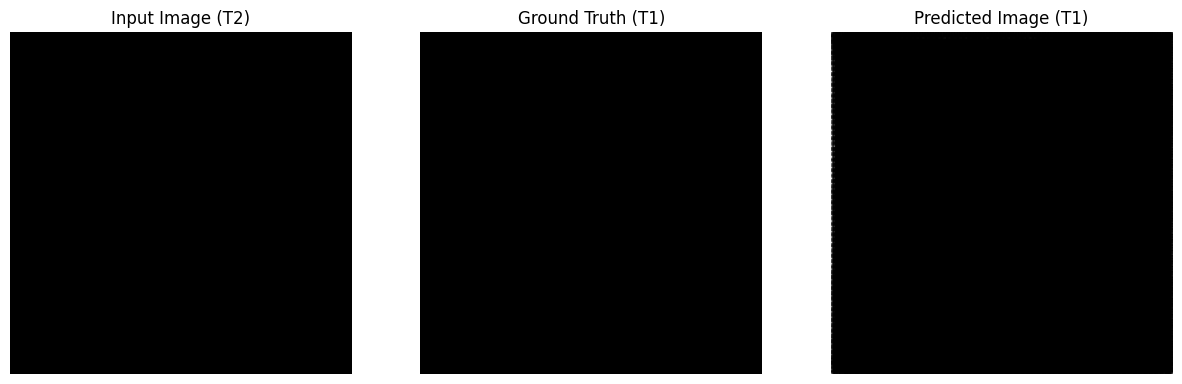

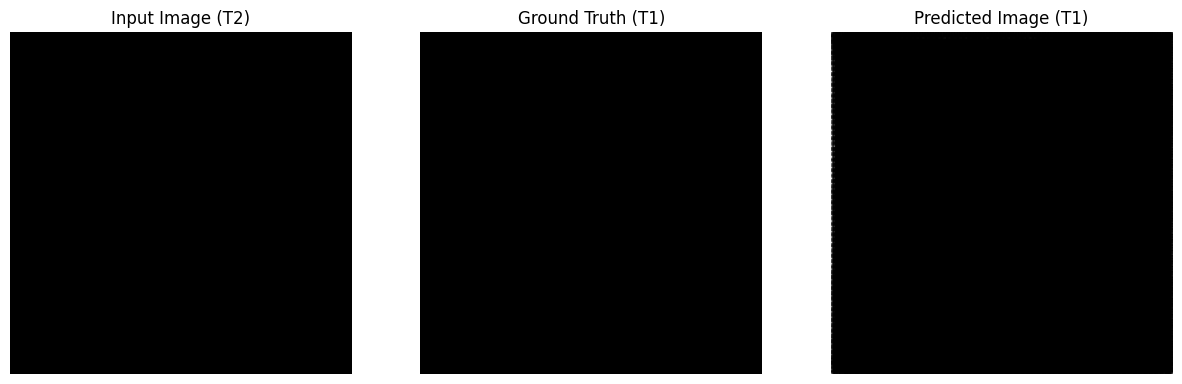

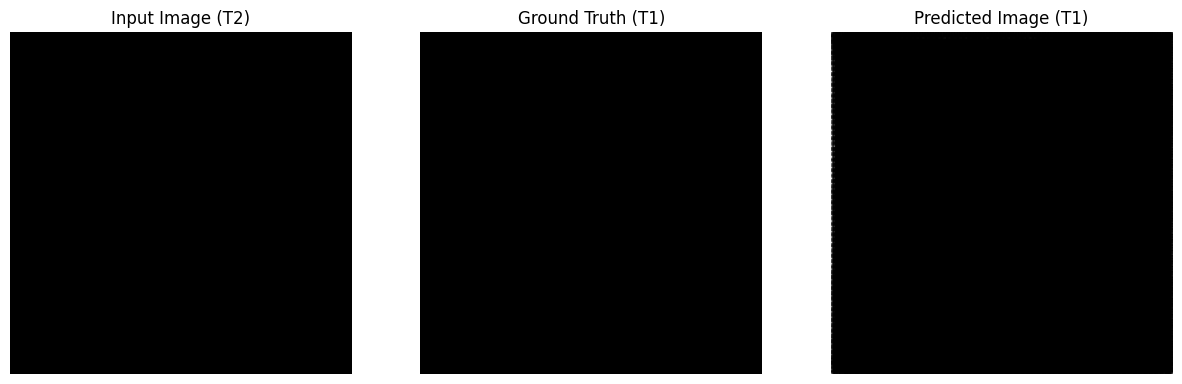

In [29]:
for input_image, real_target in test_dataset_2.take(1):
    synthetic_image = generator_t2_t1(input_image, training=False)

    print("Input min/max:",
          tf.reduce_min(input_image).numpy(),
          tf.reduce_max(input_image).numpy())

    print("Target min/max:",
          tf.reduce_min(real_target).numpy(),
          tf.reduce_max(real_target).numpy())

    print("Generated min/max:",
          tf.reduce_min(synthetic_image).numpy(),
          tf.reduce_max(synthetic_image).numpy())


for example_input, example_target in test_dataset_2.take(3):
    generate_images(generator_t2_t1, example_input, example_target)
    print("="*50)



--- Creating Comparison Grid ---


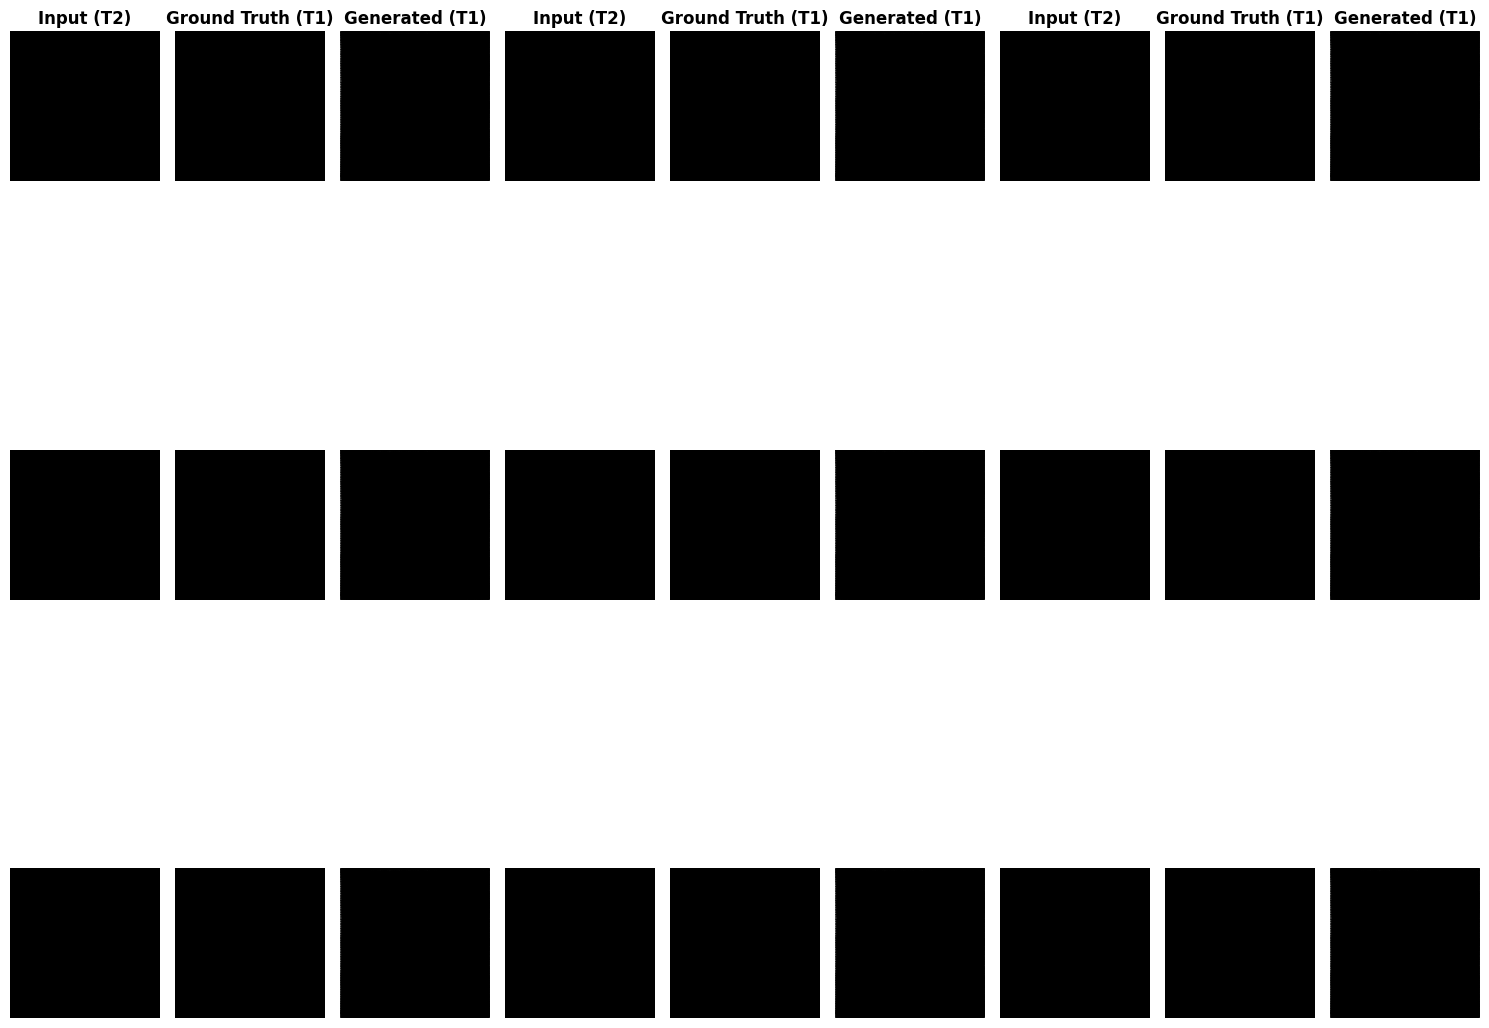

In [26]:
def create_comparison_grid(test_ds, generator, num_samples=9):
    """Create a grid comparing multiple predictions at once."""
    rows = 3
    cols = num_samples // rows
    
    fig, axes = plt.subplots(rows, cols*3, figsize=(5*cols, 5*rows))
    
    for idx, (input_image, real_target) in enumerate(test_ds.take(num_samples)):
        if idx >= num_samples:
            break
            
        row = idx // cols
        col = (idx % cols) * 3
        
        # Generate prediction
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        input_display = (input_image[0].numpy().squeeze() + 1) / 2
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Plot input
        axes[row, col].imshow(input_display, cmap='gray')
        if row == 0:
            axes[row, col].set_title('Input (T2)', fontsize=12, fontweight='bold')
        axes[row, col].axis('off')
        
        # Plot ground truth
        axes[row, col+1].imshow(real_display, cmap='gray')
        if row == 0:
            axes[row, col+1].set_title('Ground Truth (T1)', fontsize=12, fontweight='bold')
        axes[row, col+1].axis('off')
        
        # Plot prediction
        axes[row, col+2].imshow(synthetic_display, cmap='gray')
        if row == 0:
            axes[row, col+2].set_title('Generated (T1)', fontsize=12, fontweight='bold')
        axes[row, col+2].axis('off')
    
    plt.tight_layout()
    plt.savefig('comparison_grid.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n--- Creating Comparison Grid ---")
create_comparison_grid(test_dataset_2, generator_t2_t1, num_samples=9)



--- Quality Metrics Analysis ---
Calculating metrics for 20 test samples...


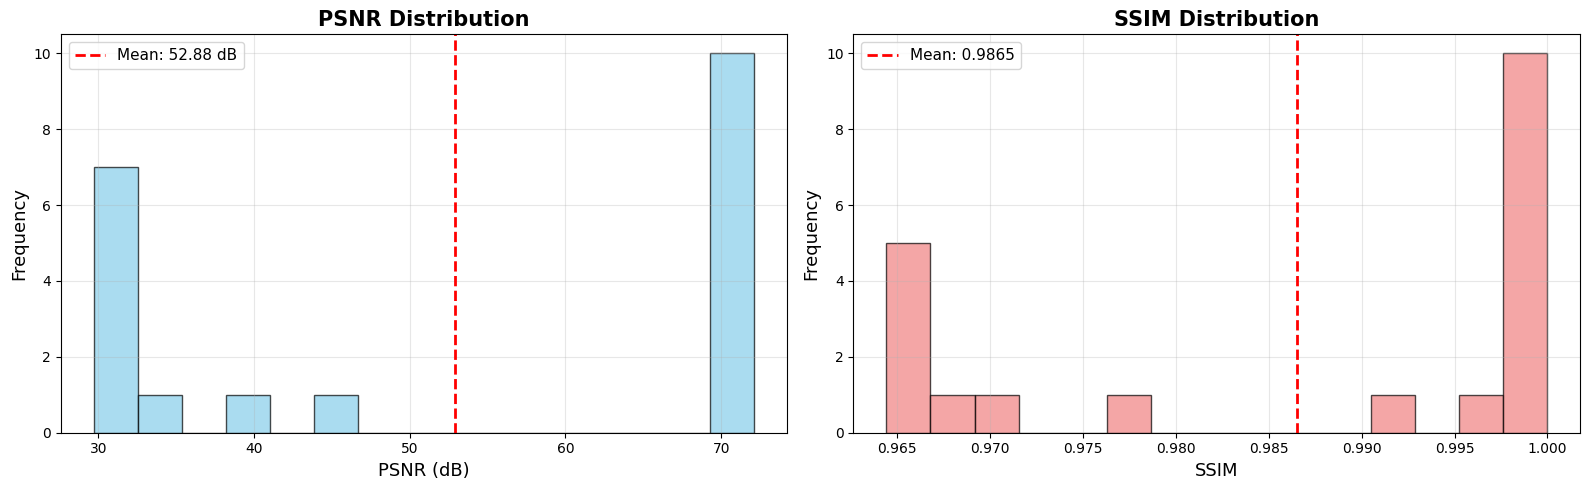


QUALITY METRICS STATISTICS
PSNR: Mean=52.88 dB, Std=19.58 dB
PSNR: Min=29.71 dB, Max=72.14 dB
SSIM: Mean=0.9865, Std=0.0156
SSIM: Min=0.9644, Max=1.0000



In [27]:
def visualize_quality_metrics(test_ds, generator, num_samples=20):
    """Calculate and visualize quality metrics distribution."""
    psnr_values = []
    ssim_values = []
    
    print(f"Calculating metrics for {num_samples} test samples...")
    for input_image, real_target in test_ds.take(num_samples):
        synthetic_image = generator(input_image, training=False)
        
        # Denormalize
        real_display = (real_target[0].numpy().squeeze() + 1) / 2
        synthetic_display = (synthetic_image[0].numpy().squeeze() + 1) / 2
        
        # Calculate metrics
        p = psnr(real_display, synthetic_display, data_range=1.0)
        s = ssim(real_display, synthetic_display, data_range=1.0, channel_axis=None)
        
        psnr_values.append(p)
        ssim_values.append(s)
    
    # Create visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # PSNR histogram
    axes[0].hist(psnr_values, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0].axvline(np.mean(psnr_values), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(psnr_values):.2f} dB')
    axes[0].set_xlabel('PSNR (dB)', fontsize=13)
    axes[0].set_ylabel('Frequency', fontsize=13)
    axes[0].set_title('PSNR Distribution', fontsize=15, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # SSIM histogram
    axes[1].hist(ssim_values, bins=15, alpha=0.7, color='lightcoral', edgecolor='black')
    axes[1].axvline(np.mean(ssim_values), color='red', linestyle='--', linewidth=2, 
                    label=f'Mean: {np.mean(ssim_values):.4f}')
    axes[1].set_xlabel('SSIM', fontsize=13)
    axes[1].set_ylabel('Frequency', fontsize=13)
    axes[1].set_title('SSIM Distribution', fontsize=15, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('quality_metrics_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    print(f"\n{'='*50}")
    print(f"QUALITY METRICS STATISTICS")
    print(f"{'='*50}")
    print(f"PSNR: Mean={np.mean(psnr_values):.2f} dB, Std={np.std(psnr_values):.2f} dB")
    print(f"PSNR: Min={np.min(psnr_values):.2f} dB, Max={np.max(psnr_values):.2f} dB")
    print(f"SSIM: Mean={np.mean(ssim_values):.4f}, Std={np.std(ssim_values):.4f}")
    print(f"SSIM: Min={np.min(ssim_values):.4f}, Max={np.max(ssim_values):.4f}")
    print(f"{'='*50}\n")

print("\n--- Quality Metrics Analysis ---")
visualize_quality_metrics(test_dataset_2, generator_t2_t1, num_samples=20)


